In [1]:
# import librarys 
import torch
import torchvision
import numpy as np
import pandas as pd

In [2]:
# import kaggle api
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
# import dataset from kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download alifarajnia/riceimt

 98% 215M/220M [00:06<00:00, 43.5MB/s]
100% 220M/220M [00:07<00:00, 32.3MB/s]


In [4]:
# open zip file
! unzip riceimt.zip

Streaming output truncated to the last 5000 lines.
  inflating: Karacadag/Karacadag (550).jpg  
  inflating: Karacadag/Karacadag (5500).jpg  
  inflating: Karacadag/Karacadag (5501).jpg  
  inflating: Karacadag/Karacadag (5502).jpg  
  inflating: Karacadag/Karacadag (5503).jpg  
  inflating: Karacadag/Karacadag (5504).jpg  
  inflating: Karacadag/Karacadag (5505).jpg  
  inflating: Karacadag/Karacadag (5506).jpg  
  inflating: Karacadag/Karacadag (5507).jpg  
  inflating: Karacadag/Karacadag (5508).jpg  
  inflating: Karacadag/Karacadag (5509).jpg  
  inflating: Karacadag/Karacadag (551).jpg  
  inflating: Karacadag/Karacadag (5510).jpg  
  inflating: Karacadag/Karacadag (5511).jpg  
  inflating: Karacadag/Karacadag (5512).jpg  
  inflating: Karacadag/Karacadag (5513).jpg  
  inflating: Karacadag/Karacadag (5514).jpg  
  inflating: Karacadag/Karacadag (5515).jpg  
  inflating: Karacadag/Karacadag (5516).jpg  
  inflating: Karacadag/Karacadag (5517).jpg  
  inflating: Karacadag/Karacada

# Load Data

In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor
# datasets for load data
# tranforms for image to pytorch tensor
dataset = datasets.ImageFolder('riceimt', transform=ToTensor())

In [ ]:
img, label = dataset[0]
print(img.shape,label)

torch.Size([3, 250, 250]) 0


So our first image in the dataset has a shape (3,250,250) which means the image has 3 channels (RGB), height 250, and width 250. The image has a label 0, which represents the Arborio class.

In [ ]:
print("Follwing classes are there : \n",dataset.classes)

Follwing classes are there : 
 ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


# splitting data

In [ ]:
from torch.utils.data import random_split

In [ ]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [ ]:
from torch.utils.data.dataloader import DataLoader

In [ ]:
Batch_size = 128
train_dl = DataLoader(train_dataset,batch_size=Batch_size, shuffle = True,
                      num_workers = 4, pin_memory = True)
test_dl = DataLoader(train_dataset,batch_size=Batch_size, num_workers = 4,
                    pin_memory = True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# show pics

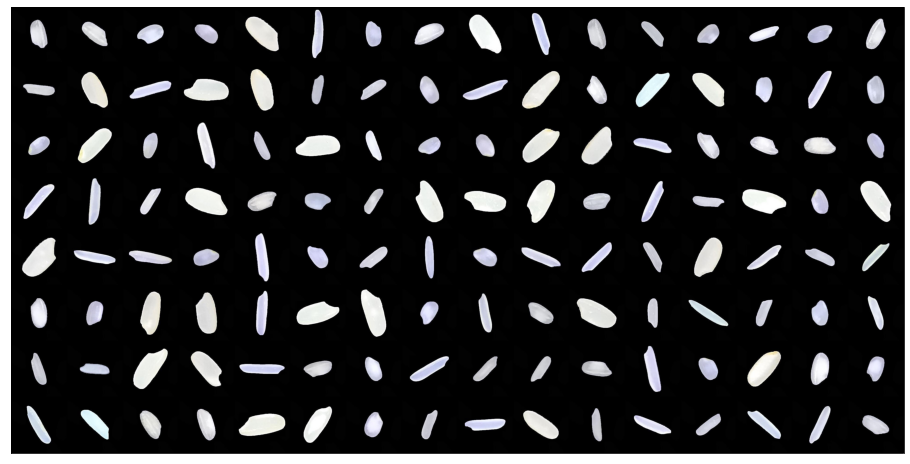

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

# modeling

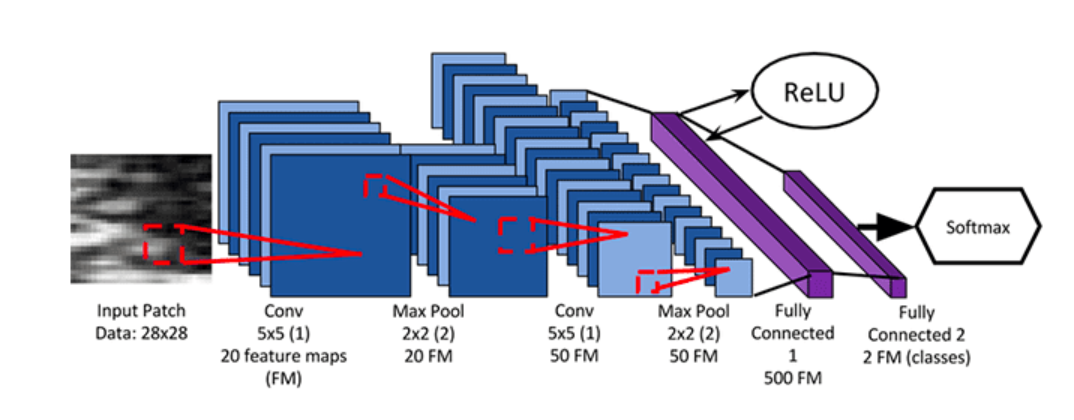

In [ ]:
# select prosscer
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# import the necessary packages
from torch.nn import Module
from torch.nn import Conv2d # conv
from torch.nn import Linear # fully connected
from torch.nn import MaxPool2d # pooling
from torch.nn import ReLU # activation
from torch.nn import LogSoftmax # activation
from torch import flatten # flatten

In [ ]:
class CNN(Module):
	def __init__(self, numChannels, classes):
		# call the parent constructor
		super(CNN, self).__init__()
		# initialize first set of CONV => RELU => POOL layers
		self.conv1 = Conv2d(in_channels=numChannels, out_channels=20,
			kernel_size=(5, 5))
		self.relu1 = ReLU()
		self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# initialize second set of CONV => RELU => POOL layers
		self.conv2 = Conv2d(in_channels=20, out_channels=50,
			kernel_size=(5, 5))
		self.relu2 = ReLU()
		self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# initialize first (and only) set of FC => RELU layers
		self.fc1 = Linear(174050, 512)
		self.relu3 = ReLU()
		# initialize our softmax classifier
		self.fc2 = Linear(512, out_features=classes)
		self.logSoftmax = LogSoftmax(dim=1)
  
	def forward(self, x):
		# pass the input through our first set of CONV => RELU =>
		# POOL layers
		x = self.conv1(x)
		x = self.relu1(x)
		x = self.maxpool1(x)
		# pass the output from the previous layer through the second
		# set of CONV => RELU => POOL layers
		x = self.conv2(x)
		x = self.relu2(x)
		x = self.maxpool2(x)
		# flatten the output from the previous layer and pass it
		# through our only set of FC => RELU layers
		x = flatten(x, 1)
		x = self.fc1(x)
		x = self.relu3(x)
		# pass the output to our softmax classifier to get our output
		# predictions
		x = self.fc2(x)
		output = self.logSoftmax(x)
		# return the output predictions
		return output

cnn = CNN(3, 5).to(device)
print(cnn)

CNN(
  (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=174050, out_features=512, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=512, out_features=5, bias=True)
  (logSoftmax): LogSoftmax(dim=1)
)


In [ ]:
import torch.optim as optim # optimizer
from torch import nn

Loss = nn.CrossEntropyLoss() 
optimizer = optim.SGD(cnn.parameters(), lr=1e-3, momentum=0.9)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute  error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dl, cnn, Loss, optimizer)
    test(test_dl, cnn, Loss)
print("Done!")

Epoch 1
-------------------------------
loss: 0.070835  [    0/60000]
loss: 0.106417  [12800/60000]
loss: 0.060192  [25600/60000]
loss: 0.067633  [38400/60000]
loss: 0.081877  [51200/60000]
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.081405 

Epoch 2
-------------------------------
loss: 0.046039  [    0/60000]
loss: 0.092863  [12800/60000]
loss: 0.066127  [25600/60000]
loss: 0.059737  [38400/60000]
loss: 0.027455  [51200/60000]
Test Error: 
 Accuracy: 97.3%, Avg loss: 0.077157 

Epoch 3
-------------------------------
loss: 0.076697  [    0/60000]
loss: 0.127257  [12800/60000]
loss: 0.050930  [25600/60000]
loss: 0.111097  [38400/60000]
loss: 0.066800  [51200/60000]
Test Error: 
 Accuracy: 97.7%, Avg loss: 0.066873 

Epoch 4
-------------------------------
loss: 0.062288  [    0/60000]
loss: 0.061171  [12800/60000]
loss: 0.056266  [25600/60000]
loss: 0.036149  [38400/60000]
loss: 0.028044  [51200/60000]
Test Error: 
 Accuracy: 97.3%, Avg loss: 0.076358 

Epoch 5
------------------------